In [39]:
using TensorOperations
using Einsum
using PyPlot
using Optim
#Size of lerning set
size_of_set=100000
#Pauli matrix generator
function pauli_matrix(n)
    if n==1
        [[0., 1.] [1., 0.]]
    elseif n==2
        [[0., im] [-im, 0.]]
    elseif n==3
        [[1., 0.] [0., -1]]
    end
end
#Density matrix
function dens_matrix(A)
    (1/2.)*([[1., 0.] [0., 1.]]+A[1]*pauli_matrix(1)+A[2]*pauli_matrix(2)+A[3]*pauli_matrix(3))
end
#Projective operator
function proj(A)
    (1/2.)*([[1., 0.] [0., 1.]]+A[1]*pauli_matrix(1)+A[2]*pauli_matrix(2)+A[3]*pauli_matrix(3))
end
#Random vector with norm 1
function randvect()
    x=randn()
    y=randn()
    z=randn()
    [x,y,z]/sqrt((x^2+y^2+z^2))
end
#Density matrix for collisions
coll_dens=[[1., 0.] [0., 0.]]
#Function for collision evolution (try fast)
###########
###########
###########
###########
###########
function channel(u,rho)
    rhor=u*kron(rho,coll_dens)*conj(transpose(u))
    rhor=reshape(rhor,(2,4,2,4))
    Id=[[1.,0.] [0.,1.]]
    @tensor rho_out[a,b]:=rhor[q,a,p,b]*Id[q,p]
    return(rho_out)
end
#Function for collision evolution for trace
function channel_left(u,tr)
    trr=transpose(u)*kron(tr,[[1.,0.] [0.,1.]])*conj(u)
    trr=reshape(trr,(2,4,2,4))
    @tensor tr_out[a,b]:=trr[p,a,q,b]*coll_dens[p,q]
    return(tr_out)
end
#Measurement
function measurement(E,rho)
    rhor=reshape(rho,(2,2,2,2))
    @tensor rho_out[a,b,c,d]:=rhor[a,f,c,j]*E[b,f]*E[j,d]
    return(reshape(rho_out,(4,4)))
end
#Measuremet from left
function measurement_left(E,tr)
    trr=reshape(tr,(2,2,2,2))
    @tensor tr_out[a,b,c,d]:=trr[a,f,c,j]*E[f,b]*E[d,j]
    return(reshape(tr_out,(4,4)))
end
#functions for gradient
function fu(y,x)
    if x!=y
        -(1./im)*(exp(-im*x)-exp(-im*y))/(x-y)
    else
        exp(-im*x)
    end
end
function fuct(y,x)
    if x!=y
        (1./im)*(exp(im*x)-exp(im*y))/(x-y)
    else
        exp(im*x)
    end
end
###################
###################
#prepare envirament
function GRD(tr_set,rho,H)
    ed=eig(H)
    u=expm(-im*H)
    envr=Complex{Float64}[]
    envl=Complex{Float64}[]
    res=zeros((8,8))
    rho_in=rho
    tr_in=[[1.,0,0,0] [0,1,0,0] [0,0,1,0] [0,0,0,1]]
    ur=reshape(u,(2,2,2,2,2,2))
    ur=permutedims(ur,(6,5,4,3,2,1))
    cur=conj(ur)
    v=ed[2]
    cv=conj(v)
    ll=ed[1]
    Fu=reshape([fu(ll[(i-1)%8+1],ll[div(i-1,8)+1]) for i in 1:64],(8,8))
    Fuct=reshape([fuct(ll[(i-1)%8+1],ll[div(i-1,8)+1]) for i in 1:64],(8,8))
    ######################
    ######################
    for i in 1:size_of_set
        append!(envr,rho_in)
        rho_in=channel(u,rho_in)
        rho_in=measurement(set[:,:,i],rho_in)
        rho_in=rho_in/trace(rho_in)
    end
    for i in size_of_set:-1:1
        tr_in=measurement_left(set[:,:,i],tr_in)
        tr_in=tr_in/trace(tr_in)
        append!(envl,tr_in)
        tr_in=channel_left(u,tr_in)
    end
    envr=reshape(envr,(4,4,size_of_set))
    envl=flipdim(reshape(envl,(4,4,size_of_set)),3)
    for i in 1:size_of_set
        l=envl[:,:,i]
        r=envr[:,:,i]
        n=trace(transpose(kron(l,eye(2,2)))*u*kron(r,coll_dens)*conj(transpose(u)))
        G1=(1/n)*kron(r,coll_dens)*conj(transpose(u))*transpose(kron(l,eye(2,2)))
        G2=(1/n)*transpose(kron(l,eye(2,2)))*u*kron(r,coll_dens)
        GG1=transpose(conj(v))*G1*v
        GG2=transpose(conj(v))*G2*v
        GGG1=GG1.*transpose(Fu)
        GGG2=GG2.*transpose(Fuct)
        grd1=v*GGG1*transpose(conj(v))
        grd2=v*GGG2*transpose(conj(v))
        grd=(-im/2)*grd1+(im/2)*grd2
        grd=grd+conj(transpose(grd))
        res=res+grd
    end
    return res
end
###################################
function llh(u,tr_set,rho)
    q=0.
    r=rho
    for k in 1:size_of_set
        r=channel(u,r)
        r=measurement(tr_set[:,:,k],r)
        p=trace(r)
        q=q+log(p)
        r=r/p
    end
    return q
end
function tovec(H)
    hh=reshape(H,(64))
    append!(real(hh),imag(hh))
end
function tomtrx(H)
    reshape(H[1:64],(8,8))+im*reshape(H[65:128],(8,8))
end

tomtrx (generic function with 1 method)

In [40]:
h=randn(2,2)+im*randn(2,2)
Hs=(0.5)*(h+conj(transpose(h)))
h=(randn(8,8)+im*randn(8,8))*0.1
H=0.7*(h+conj(transpose(h)))
H=H+kron(Hs,eye(4,4))
Hset=H
u=expm(-im*Hset)
rho=dens_matrix(randvect())
rho=kron(rho,rho)
id=eye(2,2)
set=Complex{Float64}[]
for i in 1:size_of_set
    if rand()>0.
        E=proj(randvect())
        #E=proj((1/sqrt(3))*[rand([-1,1]),rand([-1,1]),rand([-1,1])])
    else
        E=eye(2,2)
    end
    rho=channel(u,rho)
    rhoprob=measurement(E,rho)
    p=trace(rhoprob)
    if abs(trace(rhoprob))>rand()
        rho=rhoprob/p
        append!(set,E)
    else
        rho=measurement([[1.,0.] [0.,1.]]-E,rho)/(1-p)
        append!(set,[[1.,0.] [0.,1.]]-E)
    end
end
set=reshape(set,(2,2,size_of_set));
writedlm("H.txt", Hset)
writedlm("rho.txt", rho)
writedlm("trset.txt", set)
rho1=rho
u=expm(-im*Hset)
arrrx=Complex{Float32}[]
arrry=Complex{Float32}[]
arrrz=Complex{Float32}[]
for k in 1:1000
    rho1=channel(u,rho1)
end
rho1=measurement([[1.,0.] [0.,0.]],rho1)
rho1=rho1/trace(rho1)
for k in 1:40
    rhop=reshape(rho1,(2,2,2,2))
    @tensor rhopr[bb,dd]:=rhop[aa,bb,cc,dd]*id[aa,cc]
    append!(arrrx,trace(rhopr*pauli_matrix(1)))
    append!(arrry,trace(rhopr*pauli_matrix(2)))
    append!(arrrz,trace(rhopr*pauli_matrix(3)))
    rho1=channel(u,rho1)
end
writedlm("xset.txt", arrrx)
writedlm("yset.txt", arrry)
writedlm("zset.txt", arrrz)
TrueLLH=llh(u,set,rho)
writedlm("TrueLLH.txt", TrueLLH)
function setllh(H)
    h=reshape(H[1:64]+im*H[65:128],(8,8))
    real(llh(expm(-im*h),set,rho))
end
function setGRD(H)
    h=reshape(H[1:64]+im*H[65:128],(8,8))
    tovec(GRD(set,rho,h))
end
TrueLLH

-54557.80045429906 + 8.476115885912206e-15im

In [281]:
h=randn(8,8)+im*randn(8,8)
delta=(0.000001)*(h+conj(transpose(h)))
print((llh(expm(-im*(H+delta)),set,rho)-llh(expm(-im*(H)),set,rho))/trace(GRD(set,rho,H)*delta))

1.0001679138745376 + 1.529835824454254e-11im

In [44]:
#h=randn(2,2)+im*randn(2,2)
#Hs=(0.2)*(h+conj(transpose(h)))
#h=randn(4,4)+im*randn(4,4)
#Hr=(0.1)*(h+conj(transpose(h)))
#h=randn(8,8)+im*randn(8,8)
#H=kron(Hs,eye(4,4))
#Htest=H
h=(randn(2,2)+im*randn(2,2))*0.5
H=kron(h+conj(transpose(h)),eye(4,4))
writedlm("recH.txt",H)
id=eye(2,2)
eta=0.1
eee=0.1
dlt=0.7
grad=zeros(8,8)
test=Complex{Float64}[]
for i in 1:20000
    append!(test,llh(expm(-im*H),set,rho))
    grd=GRD(set,rho,H)
    grad=0.95*grad+0.05*grd
    print(norm(grad))
    print(" ")
    LLh=llh(expm(-im*(H)),set,rho)
    eta=0.00005
    ind=-1
    #while ind<0
    #    eta=eta*dlt
    #    ind=real(llh(expm(-im*(H+eta*grad)),set,rho)-LLh-eta*eee*trace(grad*grd))
    #end
    H=H+eta*grad
    writedlm("recH.txt",H)
    rho1=rho
    u=expm(-im*H)
    arrrx=Complex{Float32}[]
    arrry=Complex{Float32}[]
    arrrz=Complex{Float32}[]
    for k in 1:1000
        rho1=channel(u,rho1)
    end
    rho1=measurement([[1.,0.] [0.,0.]],rho1)
    rho1=rho1/trace(rho1)
    for k in 1:40
        rhop=reshape(rho1,(2,2,2,2))
        @tensor rhopr[bb,dd]:=rhop[aa,bb,cc,dd]*id[aa,cc]
        append!(arrrx,trace(rhopr*pauli_matrix(1)))
        append!(arrry,trace(rhopr*pauli_matrix(2)))
        append!(arrrz,trace(rhopr*pauli_matrix(3)))
        rho1=channel(u,rho1)
    end
    writedlm("xtest.txt", arrrx)
    writedlm("ytest.txt", arrry)
    writedlm("ztest.txt", arrrz)
    writedlm("test.txt", test)
end
writedlm("recH.txt", H)

1107.360643684098 1811.2262108977582 2411.6837649025797 2635.5968593000293 2589.839233952975 2309.1332079579483 2037.0916716340248 1944.4873866213659 1826.5790455686047 1643.9471605366307 1457.3971883386027 1280.8153884899907 1126.388724594201 985.4042683467158 858.6385258160235 784.1499042605471 841.6808156125061 949.6636130208194 1061.5403850889916 1166.4717194797136 1258.0637005130318 1331.623977986872 1383.1193890613818 1409.2847221058162 1407.819341383034 1377.8597716802471 1320.51529736473 1239.2059368480393 1139.8132960021235 1030.4710045337529 921.0059633485798 822.6138302363671 837.5465833103148 879.6784043321063 903.2316253960756 905.1339423719389 884.4115007217044 842.095342296448 781.1480442027081 706.5368130114455 625.7443311994947 549.8033946350879 491.7071996682528 456.37999317413244 437.7404168015921 429.81378146579556 430.175998152464 437.1798887779567 447.7139492280629 465.124873999084 500.90624242922956 522.3716122044764 529.0390169291251 521.7418387230501 502.391889

7.189144445439787 7.173561778452279 7.158005700412853 7.142466407480786 7.126943763320706 7.111446671455795 7.095992004200709 7.0806031877434545 7.065308549383231 7.050139531267937 7.035128868277613 7.02030881869494 7.005709526801224 6.991357586800007 6.977274866705877 6.963477637918349 6.949976040397281 6.9367738950211795 6.923868855176948 6.911252871063056 6.898912924618957 6.886831981891393 6.8749901032934915 6.863365649850512 6.851936523969418 6.840681384884205 6.829580781248003 6.818618146134376 6.807780603996949 6.797059546002345 6.786450940631189 6.775955360763272 6.765577725996944 6.755326778176613 6.745214326825412 6.735254317445602 6.725461787642832 6.7158517827861415 6.706438304183487 6.697233358833696 6.688246171393582 6.679482606880029 6.670944837573066 6.662631270429932 6.654536732986771 6.646652897384204 6.638968905079672 6.631472140752723 6.624149094003557 6.616986242938739 6.609970895032285 6.603091927349741 6.596340379533792 6.589709867256833 6.583196799595784 6.57680

8.117988512643748 8.108031964616426 8.097996485903723 8.087883418651275 8.077694109956903 8.067429911464238 8.057092178957175 8.046682271948146 8.036201553261522 8.025651388610878 8.015033146193225 8.004348196263772 7.993597910730659 7.982783662750484 7.971906826328934 7.960968775928193 7.9499708860828475 7.938914531019787 7.927801084284954 7.9166319183635885 7.905408404321724 7.894131911428799 7.882803806793861 7.87142545499337 7.859998217701999 7.848523453316528 7.837002516585052 7.825436758231603 7.813827524582242 7.80217615719647 7.790483992496461 7.778752361403125 7.766982588976362 7.755175994066483 7.743333888970928 7.731457579092417 7.7195483626123265 7.7076075301678335 7.695636364538966 7.683636140342635 7.671608123724395 7.659553572068471 7.647473733698968 7.6353698475968255 7.623243143115631 7.611094839698095 7.598926146604269 7.58673826263478 7.574532375873857 7.56230966341839 7.550071291129368 7.537818413383761 7.5255521728347015 7.513273700178218 7.500984113934064 7.488684

LoadError: [91mInterruptException:[39m

In [356]:
#h=randn(2,2)+im*randn(2,2)
#Hs=(0.2)*(h+conj(transpose(h)))
#h=randn(4,4)+im*randn(4,4)
#Hr=(0.1)*(h+conj(transpose(h)))
#h=randn(8,8)+im*randn(8,8)
#H=kron(Hs,eye(4,4))+kron(eye(2,2),Hr)
#Htest=H
h=(randn(8,8)+im*rand(8,8))*0.2
H=h+conj(transpose(h))
writedlm("recH.txt",H)
id=eye(2,2)
eta=0.01
eee=0.02
dlt=0.5
grad=zeros(8,8)
test=Complex{Float64}[]
for i in 1:200000
    ###
    u=expm(-im*Hset)
    set=Complex{Float64}[]
    for i in 1:size_of_set
        if rand()>0.
            #E=proj(randvect())
            E=proj((1/sqrt(3))*[rand([-1,1]),rand([-1,1]),rand([-1,1])])
        else
            E=eye(2,2)
        end
        rho=channel(u,rho)
        rhoprob=measurement(E,rho)
        p=trace(rhoprob)
        if abs(trace(rhoprob))>rand()
            rho=rhoprob/p
            append!(set,E)
        else
            rho=measurement([[1.,0.] [0.,1.]]-E,rho)/(1-p)
            append!(set,[[1.,0.] [0.,1.]]-E)
        end
    end
    set=reshape(set,(2,2,size_of_set));
    ###
    append!(test,llh(expm(-im*H),set,rho))
    grd=GRD(set,rho,H)
    grad=0.7*grad+0.3*grd
    LLh=llh(expm(-im*(H)),set,rho)
    H=H+eta*grad
    writedlm("recH.txt",H)
    rho1=rho
    u=expm(-im*H)
    arrrx=Complex{Float32}[]
    arrry=Complex{Float32}[]
    arrrz=Complex{Float32}[]
    for k in 1:1000
        rho1=channel(u,rho1)
    end
    rho1=measurement([[1.,0.] [0.,0.]],rho1)
    rho1=rho1/trace(rho1)
    for k in 1:40
        rhop=reshape(rho1,(2,2,2,2))
        @tensor rhopr[bb,dd]:=rhop[aa,bb,cc,dd]*id[aa,cc]
        append!(arrrx,trace(rhopr*pauli_matrix(1)))
        append!(arrry,trace(rhopr*pauli_matrix(2)))
        append!(arrrz,trace(rhopr*pauli_matrix(3)))
        rho1=channel(u,rho1)
    end
    writedlm("xtest.txt", arrrx)
    writedlm("ytest.txt", arrry)
    writedlm("ztest.txt", arrrz)
    writedlm("test.txt", test)
    eta=eta*0.997
end
writedlm("recH.txt", H)

LoadError: [91mInterruptException:[39m

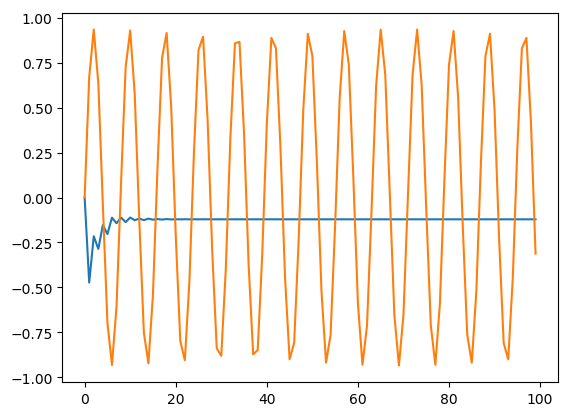

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x110924250>

In [212]:
id=eye(2,2)
rho1=rho
u=expm(-im*Hset)
arrr=Complex{Float32}[]
for k in 1:1000
    rho1=channel(u,rho1)
end
rho1=measurement([[1.,0.] [0.,0.]],rho1)
rho1=rho1/trace(rho1)
for k in 1:100
    rhop=reshape(rho1,(2,2,2,2))
    @tensor rhopr[bb,dd]:=rhop[aa,bb,cc,dd]*id[aa,cc]
    append!(arrr,trace(rhopr*pauli_matrix(1)))
    rho1=channel(u,rho1)
end
plot(arrr)
id=eye(2,2)
rho1=rho
u=expm(-im*Htest)
arrr=Complex{Float32}[]
for k in 1:1000
    rho1=channel(u,rho1)
end
rho1=measurement([[1.,0.] [0.,0.]],rho1)
rho1=rho1/trace(rho1)
for k in 1:100
    rhop=reshape(rho1,(2,2,2,2))
    @tensor rhopr[bb,dd]:=rhop[aa,bb,cc,dd]*id[aa,cc]
    append!(arrr,trace(rhopr*pauli_matrix(1)))
    rho1=channel(u,rho1)
end
plot(arrr)

In [139]:
#h=randn(2,2)+im*randn(2,2)
#Hs=(0.2)*(h+conj(transpose(h)))
#h=randn(4,4)+im*randn(4,4)
#Hr=(0.1)*(h+conj(transpose(h)))
#h=randn(8,8)+im*randn(8,8)
#H=kron(Hs,eye(4,4))
#Htest=H
h=(randn(2,2)+im*rand(2,2))*0.5
HOld=kron(h+conj(transpose(h)),eye(4,4))
B=eye(128,128)
writedlm("recH.txt",HOld)
id=eye(2,2)
eta=0.1
eee=0.1
dlt=0.7
HOld=tovec(HOld)
gradold=setGRD(HOld)
HOld=tomtrx(HOld)
dir=-gradold
test=Complex{Float64}[]
Id=eye(128,128)
for i in 1:500
    HOld=tovec(HOld)
    append!(test,setllh(HOld))
    LLh=setllh(HOld)
    eta=0.1
    ind=0.1
    dir=-B*gradold
    while ind>0
        eta=eta*dlt
        ind=real(setllh(HOld+eta*dir)-LLh-eta*eee*dot(gradold,dir))
    end
    HNew=HOld+eta*dir
    gradnew=setGRD(HNew)
    y=gradnew-gradold
    s=HNew-HOld
    B=(Id-s*transpose(y)/(dot(s,y)))*B*(Id-y*transpose(s)/(dot(s,y)))+(s*transpose(s))/(dot(s,y))
    HNew=tomtrx(HNew)
    HOld=HNew
    gradold=gradnew
    writedlm("recH.txt",HOld)
    rho1=rho
    u=expm(-im*HOld)
    arrrx=Complex{Float32}[]
    arrry=Complex{Float32}[]
    arrrz=Complex{Float32}[]
    for k in 1:1000
        rho1=channel(u,rho1)
    end
    rho1=measurement([[1.,0.] [0.,0.]],rho1)
    rho1=rho1/trace(rho1)
    for k in 1:40
        rhop=reshape(rho1,(2,2,2,2))
        @tensor rhopr[bb,dd]:=rhop[aa,bb,cc,dd]*id[aa,cc]
        append!(arrrx,trace(rhopr*pauli_matrix(1)))
        append!(arrry,trace(rhopr*pauli_matrix(2)))
        append!(arrrz,trace(rhopr*pauli_matrix(3)))
        rho1=channel(u,rho1)
    end
    writedlm("xtest.txt", arrrx)
    writedlm("ytest.txt", arrry)
    writedlm("ztest.txt", arrrz)
    writedlm("test.txt", test)
end
writedlm("recH.txt", HOld)

LoadError: [91mInterruptException:[39m

In [134]:
B

128×128 Array{Float64,2}:
  0.263358     -0.00548575  -0.0114215   …  -0.0211729   -0.00210184   0.0
 -0.00548575    0.855954    -0.00947161      0.0421258    0.065309     0.0
 -0.0114215    -0.00947161   0.555087       -0.0207146   -0.01322      0.0
  0.00652168    0.0320844   -0.0114466       0.0390106   -0.000124195  0.0
 -0.00110123    0.0116423   -0.0106444       0.0599665    0.0438074    0.0
  0.030279      0.0135239    0.00737452  …  -0.0348224   -0.0954057    0.0
 -0.00325835    0.00618329  -0.0181564       0.0257267    0.0214826    0.0
 -0.00747755    0.0535981   -0.0222076       0.10041      0.0152955    0.0
 -0.00548575   -0.144046    -0.00947161      0.0421258    0.065309     0.0
 -0.0230777     0.0671429   -0.0329652       0.211538     0.135598     0.0
  0.0179562    -0.0253455    0.0195996   …  -0.104782    -0.0390944    0.0
  0.00418648   -0.0123392    0.00508644     -0.024263    -0.0217902    0.0
 -0.00152938    0.0226213    0.00771023     -0.00621813  -0.00533843   0.0